## Computational costs and numerical properties of synchrony implementations

In [1]:
import time
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import popsynch as ps

C:\Users\franc\AppData\Local\Temp\ipykernel_14320\3758810426.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Estimate practical runtimes to compute synchrony over finite state spaces of varying size

In [2]:
num_states = [10,100,1000,1000,5000,10000]
num_trials = 5
dim = 12 # dimension of space to generate random states

timings_normalization_random = np.zeros((num_trials, len(num_states)))
timings_synchrony_random = np.zeros((num_trials, len(num_states)))

timings_normalization_cyclic = np.zeros((num_trials, len(num_states)))
timings_synchrony_cyclic = np.zeros((num_trials, len(num_states)))
for trial_ind in range(num_trials):
    for state_ind in range(len(num_states)):
        n = num_states[state_ind]
        
        # generate a random state space and Wasserstein-2 cost matrices using points sampled from [0,1]^dim
        states = np.random.rand(n,dim)
        D_random = sp.spatial.distance.squareform(sp.spatial.distance.pdist(states, metric='euclidean'))
        C_random = D_random*D_random
        
        # generate cyclic state space and Wasserstein-2 cost matrices
        D_cyclic = ps.discrete_uniform_circ_state_dm(n)
        C_cyclic = D_cyclic*D_cyclic

        # generate a random distribution on the state space
        pi = np.random.rand(n)
        pi = pi/pi.sum()

        # time to compute normalization constant and synchrony for random cost matrix
        t0 = time.time()
        normalization, _ = ps.finite_state_normalization(C_random)
        t1 = time.time()
        ps.finite_state_synchrony(pi, C_random, normalization)
        t2 = time.time()

        timings_normalization_random[trial_ind, state_ind] = t1-t0
        timings_synchrony_random[trial_ind, state_ind] = t2-t1

        # time to compute normalization constant and synchrony for cyclic cost matrix
        t0 = time.time()
        normalization, _ = ps.finite_state_normalization(C_cyclic)
        t1 = time.time()
        ps.finite_state_synchrony(pi, C_cyclic, normalization)
        t2 = time.time()

        timings_normalization_cyclic[trial_ind, state_ind] = t1-t0
        timings_synchrony_cyclic[trial_ind, state_ind] = t2-t1

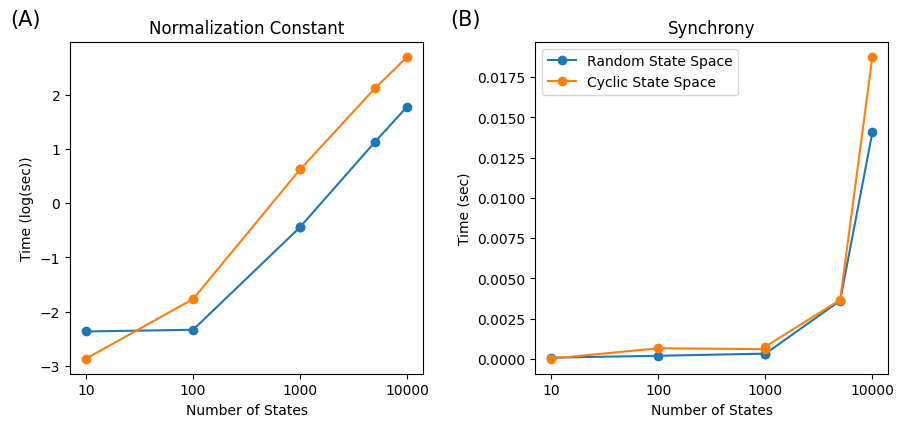

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout(pad=5.0)

ax1.plot(np.log10(num_states), np.log10(timings_normalization_random.mean(axis=0)), '-o', label="Random State Space")
ax2.plot(np.log10(num_states), timings_synchrony_random.mean(axis=0), '-o', label="Random State Space")
ax1.plot(np.log10(num_states), np.log10(timings_normalization_cyclic.mean(axis=0)), '-o', label="Cyclic State Space")
ax2.plot(np.log10(num_states), timings_synchrony_cyclic.mean(axis=0), '-o', label="Cyclic State Space")

ax1.set_title('Normalization Constant')
ax2.set_title('Synchrony')

ax1.set_xlabel('Number of States (Log Scale)')
ax2.set_xlabel('Number of States (Log Scale)')

ax1.set_ylabel('Time (log(sec))')
ax2.set_ylabel('Time (sec)')

ax1.annotate("(A)", xy=(-.17, 1.05), xycoords="axes fraction", fontsize=15)
ax2.annotate("(B)", xy=(-.24, 1.05), xycoords="axes fraction", fontsize=15)

ax1.set_xticks([1,2,3,4])
ax2.set_xticks([1,2,3,4])

ax1.set_xticklabels(['10','100','1000','10000'])
ax2.set_xticklabels(['10','100','1000','10000'])

ax2.legend()

plt.savefig('../figs/implementation_timings.pdf')

In [7]:
# The average compute time of random Euclidean state spaces with 10,000 states
timings_normalization_random.mean(axis=0)[-1]

59.903496217727664

In [11]:
# The ratio of compute times in cyclic state spaces to random state spaces
timings_normalization_cyclic.mean(axis=0)[-4]/timings_normalization_random.mean(axis=0)[-4]

11.616066014420834

### Estimate the growth of the number of W_2^2 evaluations between a uniformly random sample of size n and a fixed delta as a function of n when computing the exact synchrony of an empirical distribution on the circle

In [12]:
ns = [10,20,40,80,160,320,640,1280,2560]
n_trials = 20
np.random.seed(seed=0)

num_evals = np.zeros((len(ns), n_trials))
for trial in range(n_trials):
    for i in range(len(ns)):
        n = ns[i]
        # generate points
        x = np.random.rand(n)
        
        # compute the number of valid candidate solutions needed to find exact generalized variance of x
        # not including the antipodes themselves
        _, _, num_eval = ps.circ_synchrony(x, method='exact', return_evals=True)
        
        num_evals[i,trial] = num_eval-(n+1)

In [13]:
a, b = np.polyfit(np.log2(ns), np.log2(num_evals.mean(axis=1)), 1)

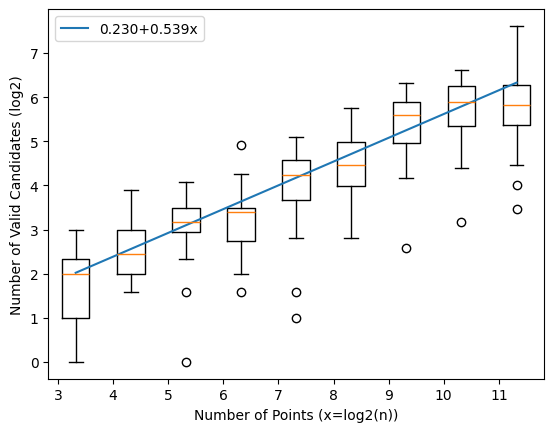

In [14]:
plt.boxplot(np.log2(num_evals).transpose(), positions=np.log2(ns))
plt.plot([np.log2(ns[0]), np.log2(ns[-1])], [b + a*np.log2(ns[0]), b + a*np.log2(ns[-1])], label=f'{b:.3f}+{a:.3f}x')
plt.xlabel('Number of Points (x=log2(n))')
plt.ylabel('Number of Valid Candidates (log2)')
plt.gca().set_xticks([int(x) for x in np.floor(np.log2(ns))])
plt.gca().set_xticklabels([int(x) for x in np.floor(np.log2(ns))])
plt.legend()
plt.savefig('../figs/valid_candidate_sols.pdf')

### Compare the number of W_2^2 evaluations needed to find the provably correct synchrony measure of an empirical distribution on the circle vs. the use of a global optimizer, as a function of the number of point masses

In [15]:
ns = [10,20,40,80,160,320,640,1280,2560,5120,10000]
n_trials = 5
np.random.seed(seed=0)

bhoptimizer_kwargs = dict()
bhoptimizer_kwargs['minimizer_kwargs'] = {"method": "BFGS"}

num_evals_exact = np.zeros((len(ns), n_trials))
num_evals_optim = np.zeros((len(ns), n_trials))
synch_diff = np.zeros((len(ns), n_trials))
barycenter_diff = np.zeros((len(ns), n_trials))

timings_exact = np.zeros((len(ns), n_trials))
timings_optim = np.zeros((len(ns), n_trials))
for trial in range(n_trials):
    for i in range(len(ns)):
        n = ns[i]
        # generate points
        x = np.random.rand(n)
        
        # compute the number of Wasserstein-2 function evaluations needed to find the exact generalized variance of x
        t0 = time.time()
        synch_exact, barycenter_exact, num_eval_exact = ps.circ_synchrony(x, method='exact', return_evals=True)
        t1 = time.time()
        num_evals_exact[i,trial] = num_eval_exact
        timings_exact[i,trial] = t1-t0
        
        bhoptimizer_kwargs['T'] = 1
        # compute the number of Wasserstein-2 function evaluations needed to find the approximate generalized variance of x by global optimization
        t0 = time.time()
        synch_optim, barycenter_optim, num_eval_optim = ps.circ_synchrony(x, method='optimize', bhoptimizer_kwargs=bhoptimizer_kwargs, return_evals=True)
        t1 = time.time()
        num_evals_optim[i,trial] = num_eval_optim
        timings_optim[i,trial] = t1-t0
        
        # compare the solutions to check success of global optimizer
        synch_diff[i,trial] = np.abs(synch_exact-synch_optim)
        barycenter_diff[i,trial] = np.abs(barycenter_exact-barycenter_optim)

/tmp/ipykernel_5895/2679696349.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  barycenter_diff[i,trial] = np.abs(barycenter_exact-barycenter_optim)


In [16]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout(pad=5.0)

ax1.plot(ns, num_evals_exact.mean(axis=1), '-o', label='Exact')
ax1.plot(ns, num_evals_optim.mean(axis=1), '-o', label='Global Optimizer')

ax2.plot(ns, timings_exact.mean(axis=1), '-o', label='Exact')
ax2.plot(ns, timings_optim.mean(axis=1), '-o', label='Global Optimizer')

ax1.set_xlabel('Number of Point Masses')
ax1.set_ylabel('Number of Wasserstein-2 Evaluations')

ax2.set_xlabel('Number of Point Masses')
ax2.set_ylabel('Time (sec)')

ax2.annotate("(A)", xy=(-.17, 1.05), xycoords="axes fraction", fontsize=15)
ax1.annotate("(B)", xy=(-.24, 1.05), xycoords="axes fraction", fontsize=15)

ax1.legend()
plt.savefig('../figs/num_evals_exact_vs_approx.pdf')

In [21]:
# Average numbers of evaluations of W_2^2 using basinhopping global optimization
num_evals_optim.mean(axis=1)

array([ 886.4,  947.6, 1073.2, 1361.2, 1442.4, 1557.2, 1795.2, 1948.4,
       2164.4, 2293.2, 2378.4])

In [17]:
# The maximum absoluite difference between the exact measure of synchrony and the approximation determined by global optimization
synch_diff.max()

2.220446049250313e-16

### Squared Wasserstein-2 distance between an empirical distribution on the circle and $\delta_{\alpha}$ as a function of $\alpha \in [0,1)$

In [3]:
np.random.seed(6)
n = 10

# generate points and their antipodes
x = np.random.rand(n)  # x = np.linspace(0,.1,n)
antip = np.unique((x + 1/2) %1)

# plot a fine approximation of the distance to delta distribution over the interval [0,1)
num_del = 1000
x_deltas = np.linspace(0,1-1/num_del,num_del)
dists = np.zeros(num_del)
dists2 = np.zeros(num_del)
for i in range(num_del):
    # Compute the Wasserstein-2 distance using the specialized method that works when comparing to a deltra distribution
    x_delta = x_deltas[i]
    dists[i] = ps.circ_wassp_to_delta(x, x_delta, p=2)

# find values at points and antipodes
dists_x =  np.zeros(n)
for j in range(n):
    dists_x[j] = ps.circ_wassp_to_delta(x, x[j], p=2)
    
dists_antip = np.zeros(len(antip))
for j in range(len(antip)):
    dists_antip[j] = ps.circ_wassp_to_delta(x, antip[j], p=2)

# find value at global minimizer
synchrony, barycenter,  = ps.circ_synchrony(x, method='exact')
    
plt.plot(x_deltas, dists, label=r'$W_2^2(\delta_{\alpha},\pi)$')    
plt.plot(x, dists_x, 'o', color='green', label=r'Support of $\pi$, {$x_i$}')
plt.plot(antip, dists_antip, 's', color='blue', label='Antipodes of {$x_i$}')
plt.plot(barycenter, (1-synchrony)**2/12, '*', color='red', label=r'Barycenter of $\pi$')
plt.xlabel(r'Phase ($\alpha$)')
plt.ylabel(r'Squared Distance Between $\delta_{\alpha}$ and $\pi$')
plt.xlim(0,1)
plt.legend()
plt.savefig('../figs/w22_circle_example.svg')

In [3]:
np.random.seed(6)
n = 10

# generate points and their antipodes
x = np.array([.25,.25,.25,.25,.25,.75,.75,.75,.75,.75])
antip = np.unique((x + 1/2) %1)

# plot a fine approximation of the distance to delta distribution over the interval [0,1)
num_del = 1000
x_deltas = np.linspace(0,1-1/num_del,num_del)
dists = np.zeros(num_del)
dists2 = np.zeros(num_del)
for i in range(num_del):
    # Compute the Wasserstein-2 distance using the specialized method that works when comparing to a deltra distribution
    x_delta = x_deltas[i]
    dists[i] = ps.circ_wassp_to_delta(x, x_delta, p=2)

# find values at points and antipodes
dists_x =  np.zeros(n)
for j in range(n):
    dists_x[j] = ps.circ_wassp_to_delta(x, x[j], p=2)
    
dists_antip = np.zeros(len(antip))
for j in range(len(antip)):
    dists_antip[j] = ps.circ_wassp_to_delta(x, antip[j], p=2)

# find value at global minimizer
synchrony, barycenter,  = ps.circ_synchrony(x, method='exact')
    
plt.plot(x_deltas, dists, label=r'$W_2^2(\delta_{\alpha},\pi)$')    
plt.plot(x, dists_x, 'o', color='green', label=r'Support of $\pi$, {$x_i$}')
plt.plot(antip, dists_antip, 's', color='blue', label='Antipodes of {$x_i$}')
plt.plot(barycenter, (1-synchrony)**2/12, '*', color='red', label=r'Barycenter of $\pi$')
plt.xlabel(r'Phase ($\alpha$)')
plt.ylabel(r'Squared Distance Between $\delta_{\alpha}$ and $\pi$')
plt.xlim(0,1)
plt.legend()
plt.savefig('../figs/w22_circle_example.svg')

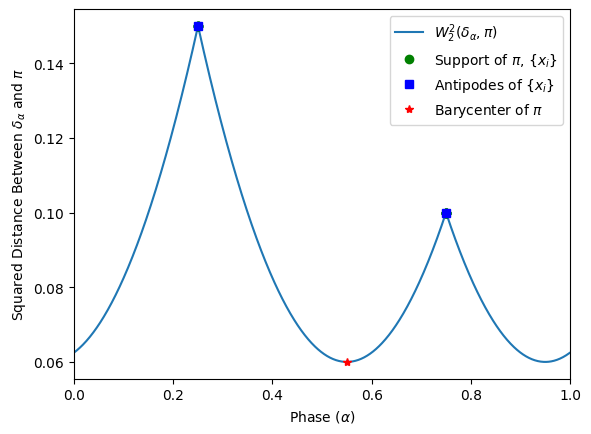

In [4]:
np.random.seed(6)
n = 10

# generate points and their antipodes
x = np.array([.25,.25,.25,.25,.75,.75,.75,.75,.75,.75])
antip = np.unique((x + 1/2) %1)

# plot a fine approximation of the distance to delta distribution over the interval [0,1)
num_del = 1000
x_deltas = np.linspace(0,1-1/num_del,num_del)
dists = np.zeros(num_del)
dists2 = np.zeros(num_del)
for i in range(num_del):
    # Compute the Wasserstein-2 distance using the specialized method that works when comparing to a deltra distribution
    x_delta = x_deltas[i]
    dists[i] = ps.circ_wassp_to_delta(x, x_delta, p=2)

# find values at points and antipodes
dists_x =  np.zeros(n)
for j in range(n):
    dists_x[j] = ps.circ_wassp_to_delta(x, x[j], p=2)
    
dists_antip = np.zeros(len(antip))
for j in range(len(antip)):
    dists_antip[j] = ps.circ_wassp_to_delta(x, antip[j], p=2)

# find value at global minimizer
synchrony, barycenter,  = ps.circ_synchrony(x, method='exact')
    
plt.plot(x_deltas, dists, label=r'$W_2^2(\delta_{\alpha},\pi)$')    
plt.plot(x, dists_x, 'o', color='green', label=r'Support of $\pi$, {$x_i$}')
plt.plot(antip, dists_antip, 's', color='blue', label='Antipodes of {$x_i$}')
plt.plot(barycenter, (1-synchrony)**2/12, '*', color='red', label=r'Barycenter of $\pi$')
plt.xlabel(r'Phase ($\alpha$)')
plt.ylabel(r'Squared Distance Between $\delta_{\alpha}$ and $\pi$')
plt.xlim(0,1)
plt.legend()
plt.savefig('../figs/w22_circle_example.svg')